In [3]:
%matplotlib inline

from collections import defaultdict
import functools
import itertools
import os

from IPython.core.display import HTML
import numpy as np
import pandas as pd
import pybedtools
import seaborn as sns

from clipper.src import CLIP_analysis
from gscripts.general import dataviz
from gscripts.rnaseq import splicing_map
from gscripts import qtools
from matplotlib import pyplot as plt

img_dir = "/projects/ps-yeolab3/encode/analysis/ad-hoc/read_density_plots"


/home/gpratt/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [4]:
submitted_datasets = pd.read_table("/home/elvannostrand/data/clip/CLIPseq_analysis/ENCODE_CLIPperv2_20161120/ALLDATASETS_submittedonly.txt")

In [7]:
# processed_peaks = submitted_datasets.copy()
# processed_peaks.index = pd.MultiIndex.from_tuples([row.values for name, row in processed_peaks[['uID', 'RBP', "Cell line"]].iterrows()])
# processed_peaks = processed_peaks.drop(["CLIP_rep1", "CLIP_rep2", "Cell line"], axis=1)

# #How many peak files don't exist
# print len(processed_peaks[(processed_peaks.gps_rep1.apply(os.path.exists) & processed_peaks.gps_rep2.apply(os.path.exists))])

# #Filter out peak files that don't exist
# processed_peaks = processed_peaks[(processed_peaks.gps_rep1.apply(os.path.exists) & processed_peaks.gps_rep2.apply(os.path.exists))]
# processed_peaks.gps_rep1 = processed_peaks.gps_rep1.apply(sort_and_return_peaks)
# processed_peaks.gps_rep2 = processed_peaks.gps_rep2.apply(sort_and_return_peaks)

In [10]:
out_dir = "/projects/ps-yeolab3/encode/analysis/binding_around_regions"

In [11]:
def format_region_binding(ip_fn, input_fn, sites_to_check):
    output = os.path.basename(ip_fn).split(".")[0]
    out_name = os.path.join(out_dir, output)
    if not os.path.exists(out_name):
        os.mkdir(out_name)
    return "python /home/bay001/software/ENCODE/encode/plot_density.py -ip {} -input {} -o {} -e bed -c {} -at bed".format(ip_fn, input_fn, out_name, sites_to_check)

In [23]:
hepg2 = """/home/gpratt/clipper/clipper/data/regions/hg19_HepG2_five_prime_ends.bed
/home/gpratt/clipper/clipper/data/regions/hg19_HepG2_poly_a_sites.bed
/home/gpratt/clipper/clipper/data/regions/hg19_HepG2_proxintron500.bed
/home/gpratt/clipper/clipper/data/regions/hg19_HepG2_start_codons.bed
/home/gpratt/clipper/clipper/data/regions/hg19_HepG2_stop_codons.bed
/home/gpratt/clipper/clipper/data/regions/hg19_HepG2_three_prime_ends.bed
/home/gpratt/clipper/clipper/data/regions/hg19_HepG2_transcription_start_sites.bed""".split("\n")

k562 = """/home/gpratt/clipper/clipper/data/regions/hg19_K562_five_prime_ends.bed
/home/gpratt/clipper/clipper/data/regions/hg19_K562_poly_a_sites.bed
/home/gpratt/clipper/clipper/data/regions/hg19_K562_start_codons.bed
/home/gpratt/clipper/clipper/data/regions/hg19_K562_stop_codons.bed
/home/gpratt/clipper/clipper/data/regions/hg19_K562_three_prime_ends.bed
/home/gpratt/clipper/clipper/data/regions/hg19_K562_transcription_start_sites.bed""".split("\n")


In [24]:
hepg2_padded = []
for bed_file in hepg2:
    bedtool = pybedtools.BedTool(bed_file)
    bedtool = bedtool.slop(b=250, genome="hg19").saveas(os.path.splitext(bed_file)[0] + ".padded.bed")
    hepg2_padded.append(bedtool.fn)
    
k562_padded = []
for bed_file in k562:
    bedtool = pybedtools.BedTool(bed_file)
    bedtool = bedtool.slop(b=250, genome="hg19").saveas(os.path.splitext(bed_file)[0] + ".padded.bed")
    k562_padded.append(bedtool.fn)

In [25]:
hepg2_files = " ".join(hepg2_padded)
k562_files = " ".join(k562_padded)

In [30]:
result = []
for name, row in submitted_datasets.iterrows():
    if row['Cell line'] == "HepG2":
        species = hepg2_files
    if row['Cell line'] == "K562":
        species = k562_files

    result.append(format_region_binding(row.CLIP_rep1, row.INPUT, species))
    result.append(format_region_binding(row.CLIP_rep2, row.INPUT, species))

In [37]:
job = qtools.Submitter(commands=result, 
                 job_name="binding_around_regions", 
                 sh_filename="/home/gpratt/projects/encode/scripts/binding_around_regions.sh",
                array=True,
                walltime="3:00:00",
                out_filename="/home/gpratt/projects/encode/scripts/binding_around_regions.out",
                err_filename="/home/gpratt/projects/encode/scripts/binding_around_regions.err",
                       queue="condo")
job.job()

running 362 tasks as an array-job.


0

In [38]:
from IPython.display import SVG

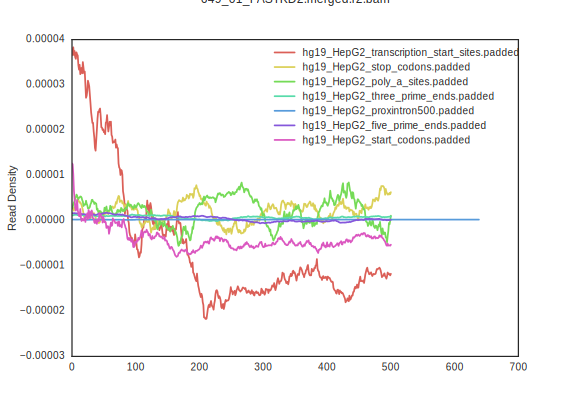

In [39]:
SVG("/projects/ps-yeolab3/encode/analysis/binding_around_regions/649_01_FASTKD2/649_01_FASTKD2.merged.r2.bam.svg")

# Make File Locations for plotting

In [44]:
submitted_datasets['CLIP_rep1_name'] = submitted_datasets.CLIP_rep1.apply(lambda x: os.path.basename(x).split(".")[0])
submitted_datasets['CLIP_rep2_name'] = submitted_datasets.CLIP_rep2.apply(lambda x: os.path.basename(x).split(".")[0])

In [68]:
region_types = [] 
for region in hepg2:
    region_types.append("_".join(os.path.basename(region).split(".")[0].split("_")[2:]))

In [78]:
def format_generic_file(row, col, region_type):
    if row['Cell line'] == "HepG2":
        species = "hg19_HepG2"
    if row['Cell line'] == "K562":
        species = "hg19_K562"
    
    return os.path.join(out_dir, row[col], "{species}_{region_type}.padded.{species}_{region_type}.padded.feature.normed_matrix.csv".format(species=species,
                                                                                                                                              region_type=region_type))

In [80]:
for region_type in region_types:
    for col in ["CLIP_rep1_name", "CLIP_rep2_name"]:
        specific_formatter = functools.partial(format_generic_file, col=col, region_type=region_type)

        submitted_datasets["{}_{}".format(col, region_type)] = submitted_datasets.apply(specific_formatter, axis=1)


# Plot Specific Locations

In [ ]:
for region_type in region_types:
    for col in ["CLIP_rep1_name", "CLIP_rep2_name"]:
        new_matrix = []
        col_name = "{}_{}".format(col, region_type)
        usable_datasets = submitted_datasets[submitted_datasets[col_name].apply(os.path.exists)]
        for x in usable_datasets[col_name]:
            new_matrix.append(pd.read_csv(x, index_col=0).mean())

        df = pd.DataFrame(new_matrix)
        df.index = usable_datasets.uID
        df.to_csv(col_name + ".csv")

In [143]:
submitted_datasets

uID      RBP Cell line  \
0         203   HNRNPC     HepG2   
1         204   RBFOX2     HepG2   
2         205  IGF2BP1     HepG2   
3         206   HNRNPK     HepG2   
4         209    SRSF7     HepG2   
5         211  IGF2BP3     HepG2   
6         215     TIA1     HepG2   
7         216    SRSF9     HepG2   
8         218    TRA2A     HepG2   
9         220  IGF2BP1      K562   
10        222   HNRNPM     HepG2   
11        223    FKBP4     HepG2   
12        224   HNRNPM      K562   
13        226  IGF2BP2      K562   
14        227     SLTM     HepG2   
15        228    SF3B4     HepG2   
16        230    BCCIP     HepG2   
17        236     FMR1      K562   
18        237     FXR2      K562   
19        240    TRA2A      K562   
20        241    DDX42      K562   
21        242    U2AF2      K562   
22        243    LARP7      K562   
23        244    U2AF1      K562   
24        245     XRN2      K562   
25        246      AUH      K562   
26        247  HNRNPA1      K562   
27        249   HNRNPU      K562   
28        256     SLTM      K562   
29        258    CPSF6      K562   
..        ...      ...       ...   
151       548   ZRANB2      K562   
152       545    EIF3H     HepG2   
153       551     YBX3      K562   
154       629    UCHL5     HepG2   
155       631   EFTUD2     HepG2   
156  235x4000     XRN2     HepG2   
157  390x4000    DDX20     HepG2   
158       285     TIA1      K562   
159       493     ILF3     HepG2   
160       571    FUBP3     HepG2   
161       572    CSTF2     HepG2   
162       575   DROSHA     HepG2   
163       610    UCHL5      K562   
164      632x     SUB1     HepG2   
165       649  FASTKD2     HepG2   
166       650  SUPV3L1     HepG2   
167       652    SUGP2     HepG2   
168       654    DHX30     HepG2   
169       655     XPO5     HepG2   
170       658     RPS5     HepG2   
171       668     PUS1      K562   
172       676   RBFOX2      K562   
173       677   GEMIN5      K562   
174       678   HNRNPL     HepG2   
175       679   RPL23A     HepG2   
176       682    DHX30      K562   
177       684  ZC3H11A      K562   
178       693   SERBP1      K562   
179       695    MATR3     HepG2   
180       696    PTBP1     HepG2   

                                             CLIP_rep1  \
0    /projects/ps-yeolab3/encode/analysis/encode_v1...   
1    /projects/ps-yeolab3/encode/analysis/encode_v1...   
2    /projects/ps-yeolab3/encode/analysis/encode_v1...   
3    /projects/ps-yeolab3/encode/analysis/encode_v1...   
4    /projects/ps-yeolab3/encode/analysis/encode_v1...   
5    /projects/ps-yeolab3/encode/analysis/encode_v1...   
6    /projects/ps-yeolab3/encode/analysis/encode_v1...   
7    /projects/ps-yeolab3/encode/analysis/encode_v1...   
8    /projects/ps-yeolab3/encode/analysis/encode_v1...   
9    /projects/ps-yeolab3/encode/analysis/encode_v1...   
10   /projects/ps-yeolab3/encode/analysis/encode_v1...   
11   /projects/ps-yeolab3/encode/analysis/encode_v1...   
12   /projects/ps-yeolab3/encode/analysis/encode_v1...   
13   /projects/ps-yeolab3/encode/analysis/encode_v1...   
14   /projects/ps-yeolab3/encode/analysis/encode_v1...   
15   /projects/ps-yeolab3/encode/analysis/encode_v1...   
16   /projects/ps-yeolab3/encode/analysis/encode_v1...   
17   /projects/ps-yeolab3/encode/analysis/encode_v1...   
18   /projects/ps-yeolab3/encode/analysis/encode_v1...   
19   /projects/ps-yeolab3/encode/analysis/encode_v1...   
20   /projects/ps-yeolab3/encode/analysis/encode_v1...   
21   /projects/ps-yeolab3/encode/analysis/encode_v1...   
22   /projects/ps-yeolab3/encode/analysis/encode_v1...   
23   /projects/ps-yeolab3/encode/analysis/encode_v1...   
24   /projects/ps-yeolab3/encode/analysis/encode_v1...   
25   /projects/ps-yeolab3/encode/analysis/encode_v1...   
26   /projects/ps-yeolab3/encode/analysis/encode_v1...   
27   /projects/ps-yeolab3/encode/analysis/encode_v1...   
28   /projects/ps-yeolab3/encode/analysis/encode_v1...   
29   /projects/ps-yeolab3/encode/anal

# Transcription Start

In [145]:
ids = submitted_datasets[['uID', 'RBP', 'Cell line']]

In [200]:
def format_index_name(df):
    #Should really turn this into a multiindex
    named_df = pd.merge(df, ids, left_index=True, right_on="uID")
    named_df.index = pd.MultiIndex.from_arrays([named_df['uID'].values, named_df['RBP'].values, named_df['Cell line'].values])    
    named_df = named_df.drop(["uID", "RBP", "Cell line"], axis=1)
    return named_df

In [180]:
import matplotlib.ticker as plticker
loc = plticker.MultipleLocator(base=50)

#Don't ask my why this works... 
locations = [0] + range(-250, 251)[::50]

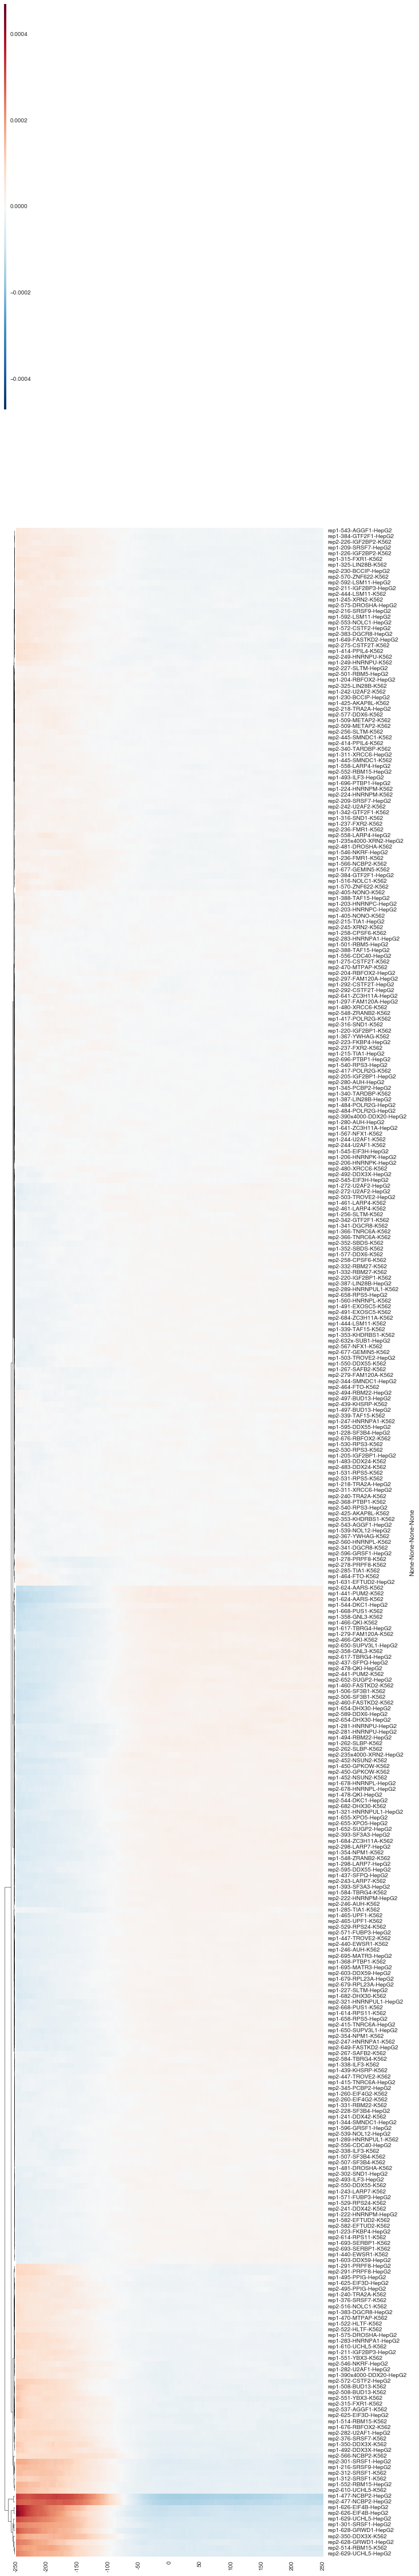

In [207]:
df = pd.read_csv("CLIP_rep1_name_transcription_start_sites.csv", index_col=0)
df_rep1 = format_index_name(df)

df = pd.read_csv("CLIP_rep2_name_transcription_start_sites.csv", index_col=0)
df_rep2 = format_index_name(df)

merged_df = pd.concat({"rep1": df_rep1, "rep2": df_rep2})
cg = sns.clustermap(merged_df, col_cluster=False, figsize=(10,80))
foo = plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
foo = cg.ax_heatmap.xaxis.set_major_locator(loc)
foo = cg.ax_heatmap.xaxis.set_ticklabels(locations)

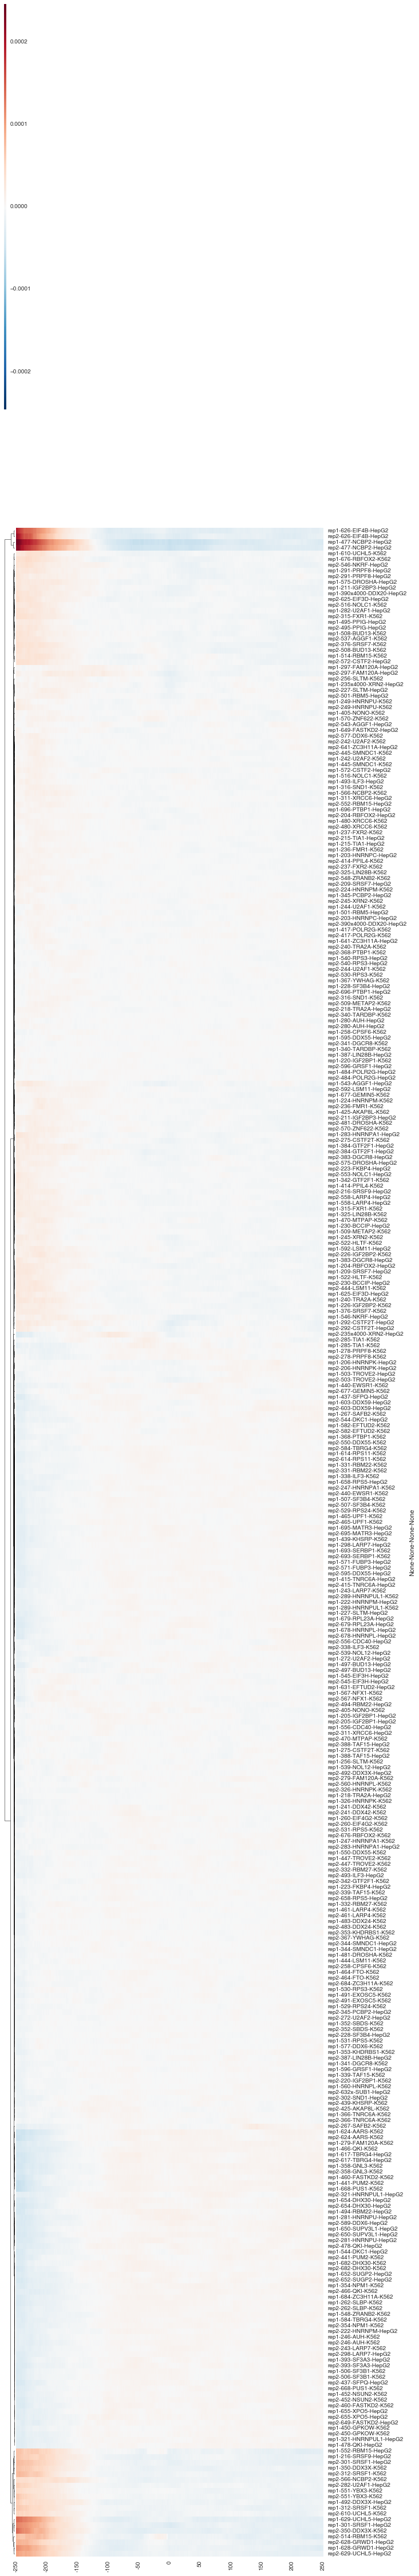

In [208]:
df = pd.read_csv("CLIP_rep1_name_start_codons.csv", index_col=0)
df_rep1 = format_index_name(df)

df = pd.read_csv("CLIP_rep2_name_start_codons.csv", index_col=0)
df_rep2 = format_index_name(df)

merged_df = pd.concat({"rep1": df_rep1, "rep2": df_rep2})
cg = sns.clustermap(merged_df, col_cluster=False, figsize=(10,80))
foo = plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
foo = cg.ax_heatmap.xaxis.set_major_locator(loc)
foo = cg.ax_heatmap.xaxis.set_ticklabels(locations)

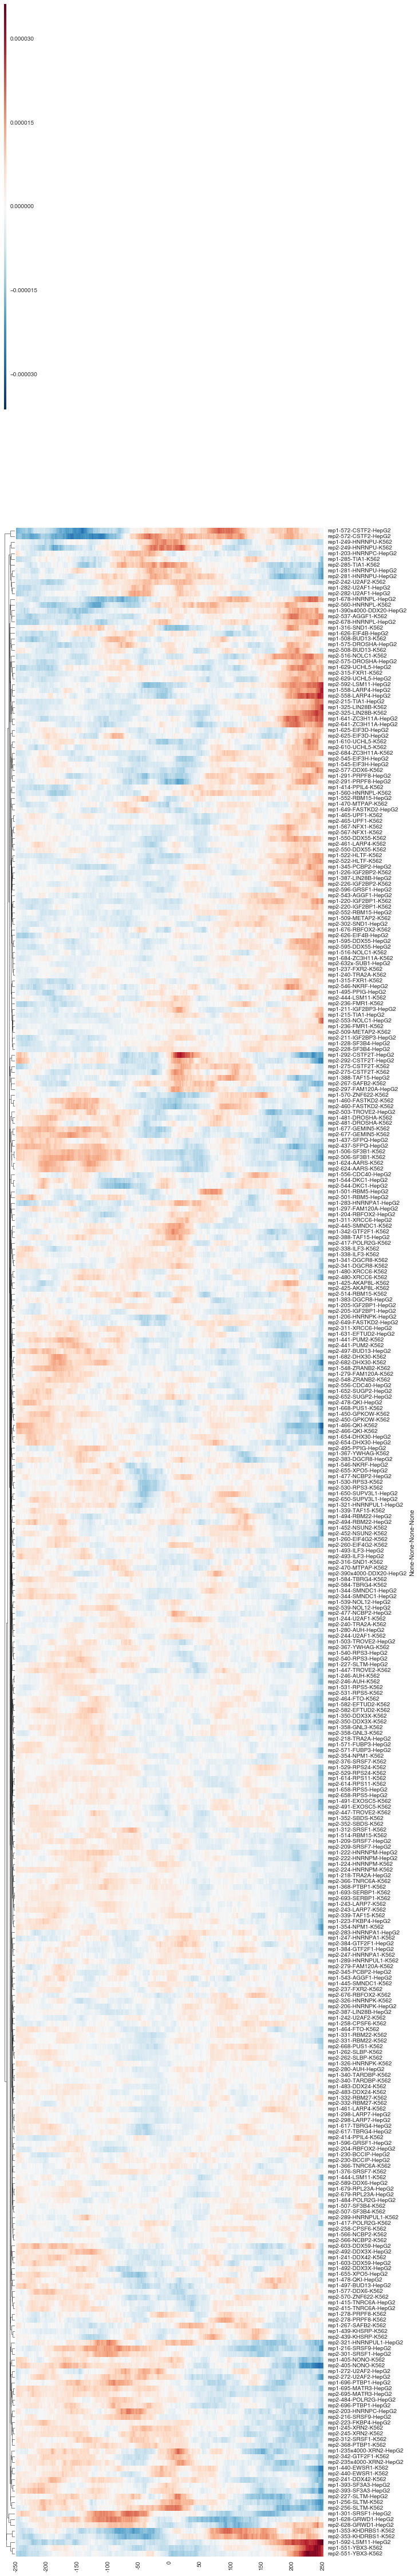

In [210]:
df = pd.read_csv("CLIP_rep1_name_stop_codons.csv", index_col=0)
df_rep1 = format_index_name(df)

df = pd.read_csv("CLIP_rep2_name_stop_codons.csv", index_col=0)
df_rep2 = format_index_name(df)

merged_df = pd.concat({"rep1": df_rep1, "rep2": df_rep2})
cg = sns.clustermap(merged_df, col_cluster=False, figsize=(10,80))
foo = plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
foo = cg.ax_heatmap.xaxis.set_major_locator(loc)
foo = cg.ax_heatmap.xaxis.set_ticklabels(locations)

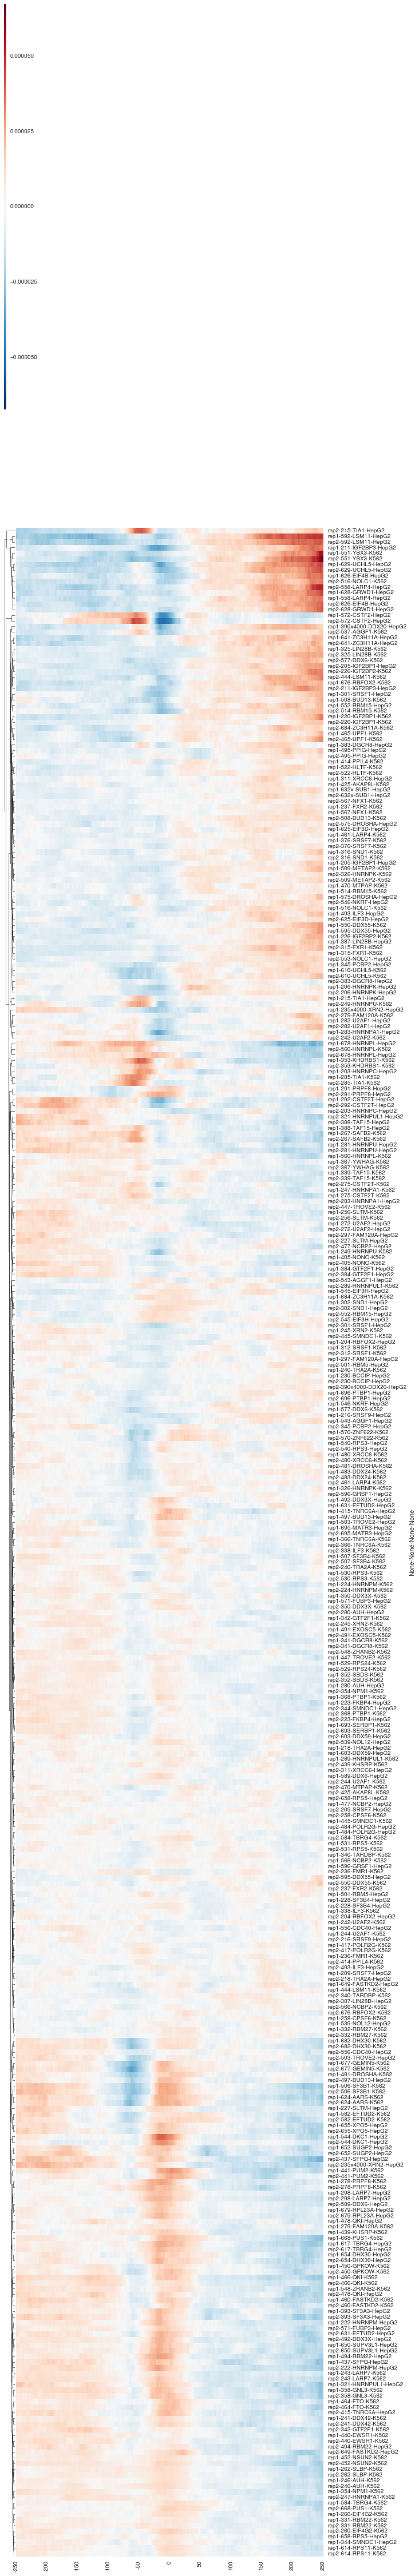

In [211]:
df = pd.read_csv("CLIP_rep1_name_poly_a_sites.csv", index_col=0)
df_rep1 = format_index_name(df)

df = pd.read_csv("CLIP_rep2_name_poly_a_sites.csv", index_col=0)
df_rep2 = format_index_name(df)

merged_df = pd.concat({"rep1": df_rep1, "rep2": df_rep2})
cg = sns.clustermap(merged_df, col_cluster=False, figsize=(10,80))
foo = plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
foo = cg.ax_heatmap.xaxis.set_major_locator(loc)
foo = cg.ax_heatmap.xaxis.set_ticklabels(locations)